###  Photosynthetic Electron Transport Chain mathematical model (version from 2014)
With this Notebook you can reproduce the results presented in 

Oliver Ebenhöh, Geoffrey Fucile, Giovanni Finazzi, Jean‐David Rochaix and Michel Goldschmidt‐Clermont (2014)
"Short-term acclimation of the photosynthetic electron transfer chain to changing light: a mathematical model"
*Phil Trans Roy Soc B* 369 doi:10.1098/rstb.2013.0223

The mathematical model of the photosynthetic electron transport chain has been implemented using the modelbase1.0 software developed at the University of Dusseldorf.

In [1]:
# I want to have my figures active here (e.g., zoom into my plots)
%matplotlib notebook

In [2]:
from modelbase.ode import Model, Simulator

import numpy as np
import matplotlib.pyplot as plt

In [3]:
import petc_model_file

In [4]:
#from petc_y0_values_10000 import y0dark12_petc, y0dark2_petc, y0high2_petc

In [5]:
petc_model_file.m.get_stoichiometric_df()

vATPconsumption  vATPsynthase  vB6f  vCyc  vFNR  vLeak  \
ATP               -1.0      1.000000  0.00   0.0   0.0   0.00   
Fd                 0.0      0.000000  0.00   2.0   2.0   0.00   
H                  0.0     -0.046667  0.04   0.0   0.0  -0.01   
LHC                0.0      0.000000  0.00   0.0   0.0   0.00   
NADPH              0.0      0.000000  0.00   0.0   1.0   0.00   
PC                 0.0      0.000000 -2.00   0.0   0.0   0.00   
PQ                 0.0      0.000000  1.00  -1.0   0.0   0.00   

       vNADPHconsumption  vNDH  vPS1  vPS2  vPTOX  vSt12  vSt21  
ATP                  0.0   0.0   0.0  0.00    0.0    0.0    0.0  
Fd                   0.0   0.0  -1.0  0.00    0.0    0.0    0.0  
H                    0.0   0.0   0.0  0.02    0.0    0.0    0.0  
LHC                  0.0   0.0   0.0  0.00    0.0   -1.0    1.0  
NADPH               -1.0   0.0   0.0  0.00    0.0    0.0    0.0  
PC                   0.0   0.0   1.0  0.00    0.0    0.0    0.0  
PQ                   0.0  -1.0   0.0 -1.00    1.0    0.0    0.0

In [6]:
# add two new compounds
petc_model_file.m.add_compounds(['Vx', 'Psbs'])

# add two pools of the two compounds as parameters
petc_model_file.m.add_parameters({"Psbstot": 1., # relative pool of PsbS
     "Xtot": 1. # relative pool of carotenoids (V+A+Z)]
                  })

# set the derived compounds based on the conservation 
def xmoiety(Vx, Xtot):
    return Xtot - Vx

petc_model_file.m.add_algebraic_module(
    module_name="xantophylls_alm",
    function=xmoiety,
    compounds=["Vx"],
    derived_compounds=["Zx"],
    parameters=['Xtot']
)

def psbsmoiety(Psbs, Psbstot):
    return Psbstot - Psbs

petc_model_file.m.add_algebraic_module(
    module_name="psbs_alm",
    function=psbsmoiety,
    compounds=["Psbs"],
    derived_compounds=["Psbsp"],
    parameters=['Psbstot']
)

# add the four reactions and parameters needed to run it
petc_model_file.m.add_parameters({ # quencher fitted parameters
     "gamma0": 0.1,          # slow quenching of Vx present despite lack of protonation
     "gamma1": 0.25,         # fast quenching present due to the protonation
     "gamma2": 0.6,          # slow quenching of Zx present despite lack of protonation
     "gamma3": 0.15,         # fastest possible quenching

#     # non-photochemical quenching PROTONATION
     "kDeprotonation": 0.0096,
     "kProtonationL": 0.0096,
     "kphSatLHC": 5.8,
     #"nH": 5.,
     #"NPQsw": 5.8,

#     # non-photochemical quenching XANTOPHYLLS
     "kDeepoxV": 0.0024,
     "kEpoxZ": 0.00024,      # 6.e-4        # converted to [1/s]
     "kphSat": 5.8,          # [-] half-saturation pH value for activity de-epoxidase highest activity at ~pH 5.8
     "kHillX": 5.,     # [-] hill-coefficient for activity of de-epoxidase
     "kHillL": 3.,     # [-] hill-coefficient for activity of de-epoxidase
     "kZSat": 0.12,          # [-] half-saturation constant (relative conc. of Z) for quenching of Z
 })

def vDeepox(Vx, H, nH, kDeepoxV, kphSat):
    """
    activity of xantophyll cycle: de-epoxidation of violaxanthin, modelled by Hill kinetics
    """
    vf = kDeepoxV * ((H ** nH)/ (H ** nH + calculate_pHinv(kphSat) ** nH)) * Vx
    return vf

petc_model_file.m.add_reaction(
    rate_name='vDeepox',
    function=vDeepox,
    stoichiometry= {"Vx": -1},
    modifiers=["H"],
    parameters=["kHillX", "kDeepoxV", "kphSat"],
    reversible=False,
)

def vEpox(Zx, kEpoxZ):
    """
    activity of xantophyll cycle: epoxidation
    """
    vr = kEpoxZ * Zx
    return vr

petc_model_file.m.add_reaction(
    rate_name='vEpox',
    function=vEpox,
    stoichiometry= {"Vx": 1},
    dynamic_variables=["Zx"],
    parameters=["kEpoxZ"],
    reversible=True,
)

def vLhcprotonation(Psbs, H, nH, kProtonationL, kphSatLHC):
    """
    activity of PsbS protein protonation: protonation modelled by Hill kinetics
    """
    vf = kProtonationL * ((H ** nH)/ (H ** nH + calculate_pHinv(kphSatLHC) ** nH)) * Psbs
    return vf

petc_model_file.m.add_reaction(
    rate_name='vLhcprotonation',
    function=vLhcprotonation,
    stoichiometry= {"Psbs": -1},
    modifiers=["H"],
    parameters=["kHillL", "kProtonationL", "kphSatLHC"],
    reversible=False,
)

def vLhcdeprotonation(Psbsp, kDeprotonation):
    """
    activity of PsbS protein protonation: deprotonation
    """
    vr = kDeprotonation * Psbsp
    return vr

petc_model_file.m.add_reaction(
    rate_name='vLhcdeprotonation',
    function=vLhcdeprotonation,
    stoichiometry= {"Psbs": 1},
    dynamic_variables=["Psbsp"],
    parameters=["kDeprotonation"],
    reversible=True,
)

In [7]:
petc_model_file.m.get_stoichiometric_df()

vATPconsumption  vATPsynthase  vB6f  vCyc  vDeepox  vEpox  vFNR  vLeak  \
ATP               -1.0      1.000000  0.00   0.0      0.0    0.0   0.0   0.00   
Fd                 0.0      0.000000  0.00   2.0      0.0    0.0   2.0   0.00   
H                  0.0     -0.046667  0.04   0.0      0.0    0.0   0.0  -0.01   
LHC                0.0      0.000000  0.00   0.0      0.0    0.0   0.0   0.00   
NADPH              0.0      0.000000  0.00   0.0      0.0    0.0   1.0   0.00   
PC                 0.0      0.000000 -2.00   0.0      0.0    0.0   0.0   0.00   
PQ                 0.0      0.000000  1.00  -1.0      0.0    0.0   0.0   0.00   
Psbs               0.0      0.000000  0.00   0.0      0.0    0.0   0.0   0.00   
Vx                 0.0      0.000000  0.00   0.0     -1.0    1.0   0.0   0.00   

       vLhcdeprotonation  vLhcprotonation  vNADPHconsumption  vNDH  vPS1  \
ATP                  0.0              0.0                0.0   0.0   0.0   
Fd                   0.0              0.0                0.0   0.0  -1.0   
H                    0.0              0.0                0.0   0.0   0.0   
LHC                  0.0              0.0                0.0   0.0   0.0   
NADPH                0.0              0.0               -1.0   0.0   0.0   
PC                   0.0              0.0                0.0   0.0   1.0   
PQ                   0.0              0.0                0.0  -1.0   0.0   
Psbs                 1.0             -1.0                0.0   0.0   0.0   
Vx                   0.0              0.0                0.0   0.0   0.0   

       vPS2  vPTOX  vSt12  vSt21  
ATP    0.00    0.0    0.0    0.0  
Fd     0.00    0.0    0.0    0.0  
H      0.02    0.0    0.0    0.0  
LHC    0.00    0.0   -1.0    1.0  
NADPH  0.00    0.0    0.0    0.0  
PC     0.00    0.0    0.0    0.0  
PQ    -1.00    1.0    0.0    0.0  
Psbs   0.00    0.0    0.0    0.0  
Vx     0.00    0.0    0.0    0.0

In [8]:
def quencher(Psbs, Vx, Psbsp, Zx, y0, y1, y2, y3, kZSat):
    """ 
    co-operatiove 4-state quenching mechanism
    
    Comment:
        seems like this can't reach 1, so I've checked the max value and normalized it
        for i in np.linspace(0,1,100):
            for j in np.linspace(0,1,100):
                a = np.hstack((a, vQuencher4states(p, i, j)))
        max(a)
    """
    ZAnt = Zx / (Zx + kZSat)
    Q = (y0 * Vx * Psbs + y1 * Vx * Psbsp + y2 * ZAnt * Psbsp + y3 * ZAnt * Psbs)#/0.5625
    #Q = (y0 * (1-ZAnt) * Psbs + y1 * (1-ZAnt) * Psbsp + y2 * ZAnt * Psbsp + y3 * ZAnt * Psbs)#/0.5625
    return Q

petc_model_file.m.add_algebraic_module(
    module_name="quencher",
    function=quencher,
    compounds=["Psbs", "Vx", "Psbsp", "Zx"],
    derived_compounds=["Q"],
    modifiers=None,
    parameters=["gamma0", "gamma1", "gamma2", "gamma3", "kZSat"],
)

In [9]:
petc_model_file.m.get_stoichiometric_df()

vATPconsumption  vATPsynthase  vB6f  vCyc  vDeepox  vEpox  vFNR  vLeak  \
ATP               -1.0      1.000000  0.00   0.0      0.0    0.0   0.0   0.00   
Fd                 0.0      0.000000  0.00   2.0      0.0    0.0   2.0   0.00   
H                  0.0     -0.046667  0.04   0.0      0.0    0.0   0.0  -0.01   
LHC                0.0      0.000000  0.00   0.0      0.0    0.0   0.0   0.00   
NADPH              0.0      0.000000  0.00   0.0      0.0    0.0   1.0   0.00   
PC                 0.0      0.000000 -2.00   0.0      0.0    0.0   0.0   0.00   
PQ                 0.0      0.000000  1.00  -1.0      0.0    0.0   0.0   0.00   
Psbs               0.0      0.000000  0.00   0.0      0.0    0.0   0.0   0.00   
Vx                 0.0      0.000000  0.00   0.0     -1.0    1.0   0.0   0.00   

       vLhcdeprotonation  vLhcprotonation  vNADPHconsumption  vNDH  vPS1  \
ATP                  0.0              0.0                0.0   0.0   0.0   
Fd                   0.0              0.0                0.0   0.0  -1.0   
H                    0.0              0.0                0.0   0.0   0.0   
LHC                  0.0              0.0                0.0   0.0   0.0   
NADPH                0.0              0.0               -1.0   0.0   0.0   
PC                   0.0              0.0                0.0   0.0   1.0   
PQ                   0.0              0.0                0.0  -1.0   0.0   
Psbs                 1.0             -1.0                0.0   0.0   0.0   
Vx                   0.0              0.0                0.0   0.0   0.0   

       vPS2  vPTOX  vSt12  vSt21  
ATP    0.00    0.0    0.0    0.0  
Fd     0.00    0.0    0.0    0.0  
H      0.02    0.0    0.0    0.0  
LHC    0.00    0.0   -1.0    1.0  
NADPH  0.00    0.0    0.0    0.0  
PC     0.00    0.0    0.0    0.0  
PQ    -1.00    1.0    0.0    0.0  
Psbs   0.00    0.0    0.0    0.0  
Vx     0.00    0.0    0.0    0.0

In [10]:
petc_model_file.m.get_derived_compounds()

['PQred',
 'PCred',
 'Fdred',
 'ADP',
 'NADP',
 'LHCp',
 'ps2cs',
 'B0',
 'B1',
 'B2',
 'B3',
 'A1',
 'Fluo',
 'pH',
 'Zx',
 'Psbsp',
 'Q']

In [11]:
def ps2states(PQ, PQred, ps2cs, Q, PSIItot, k2, kF, _kH, kH0, Keq_PQred, kPQred, pfd):
    L = ps2cs * pfd
    kH = kH0 + _kH * Q
    k3p = kPQred * PQ
    k3m = kPQred * PQred / Keq_PQred
   
    Bs = []

    
    if isinstance(kH, float) and isinstance(PQ, np.ndarray):
        kH = np.repeat(kH, len(PQ))
      
    
    for L, kH, k3p, k3m in zip(L, kH, k3p, k3m):
        M = np.array(
            [
                [-L - k3m, kH + kF, k3p, 0],
                [L, -(kH + kF + k2), 0, 0],
                [0, 0, L, -(kH + kF)],
                [1, 1, 1, 1],
            ]
        )
        A = np.array([0, 0, 0, PSIItot])
        B0, B1, B2, B3 = np.linalg.solve(M, A)
        Bs.append([B0, B1, B2, B3])
    return np.array(Bs).T


petc_model_file.m.add_algebraic_module(
    module_name="ps2states",
    function=ps2states,
    compounds=["PQ", "PQred", "ps2cs", "Q"],
    derived_compounds=["B0", "B1", "B2", "B3"],
    parameters=["PSIItot", "k2", "kF", "kH", "kH0", "Keq_PQred", "kPQred", "pfd"],
)

def fluorescence(Q, B0, B2, ps2cs, k2, kF, kH, kH0):
    fluo = (ps2cs * kF * B0) / (kF + kH0 + k2 + kH * Q) + (ps2cs * kF * B2) / (kF + kH0+ kH * Q)
    return fluo

petc_model_file.m.add_algebraic_module(
    module_name="fluorescence",
    function=fluorescence,
    compounds=["Q", "B0", "B2", "ps2cs"],
    derived_compounds=["Fluo"],
    modifiers=None,
    parameters=["k2","kF", "kH", "kH0"]
)

In [12]:
from petc_model_file import calculate_pHinv

In [13]:
calculate_pHinv

<function petc_model_file.calculate_pHinv(x)>

In [14]:
petc_model_file.m.get_parameter("kH")

0.0

# Set initial conditions using dictionary
y0new = {#"B":  m.get_parameter("PSIItot"),  #photosystem II protein concentration
       "PQ":17.5,  # oxidised plastoquinone
       "PC":0.0202,  # oxidised plastocyan
       "Fd":5.0,  # oxidised ferrodoxin
       "ATP": 0.0,# stromal concentration of ATP
       "NADPH": 0.0,  # stromal concentration of NADPH
       "H": calculate_pHinv(7.2),  # lumenal protons
       "LHC": 0.9,
       "Vx": 0.9,
     "Psbs":0.9}

In [15]:
y0dark12_petc = {
        "PQ":1.70731708e+01,
        "PC":4.58888232e-05,
        "Fd":4.99999991e+00,
        "ATP":9.70155448e-09,
        "NADPH":2.97916077e-13,
        "H":1.92236676e-05,
        "LHC":9.02053976e-01,
        "Psbs":9.00000000e-01,
        "Vx":9.00000000e-01,
}

y0dark2_petc = {
        "PQ":5.39330196e-08,
        "PC":1.17541855e-06,
        "Fd":4.99999990e+00,
        "ATP":9.49136994e-09,
        "NADPH":3.17019520e-13,
        "H":1.91336521e-05,
        "LHC":2.70833333e-01,
        "Psbs":4.50000000e-01,
        "Vx":4.50000000e-01,
}

y0high2_petc = {
        "PQ":1.70731708e+01,
        "PC":4.58888245e-05,
        "Fd":4.99999991e+00,
        "ATP":9.70155445e-09,
        "NADPH":2.97916100e-13,
        "H":1.92236676e-05,
        "LHC":9.02053729e-01,
        "Psbs":9.50105123e-01,
        "Vx":9.99999972e-01,
}

y0dark12_petc = {
        "PQ":1.70731708e+01,
        "PC":4.58888232e-05,
        "Fd":4.99999991e+00,
        "ATP":9.70155448e-09,
        "NADPH":2.97916077e-13,
        "H":calculate_pHinv(7.2),
        "LHC":9.02053976e-01,
        "Psbs":9.00000000e-01,
        "Vx":9.00000000e-01,
}

y0dark2_petc = {
        "PQ":5.39330196e-08,
        "PC":1.17541855e-06,
        "Fd":4.99999990e+00,
        "ATP":9.49136994e-09,
        "NADPH":3.17019520e-13,
        "H":calculate_pHinv(7.2),
        "LHC":2.70833333e-01,
        "Psbs":4.50000000e-01,
        "Vx":4.50000000e-01,
}

y0high2_petc = {
        "PQ":1.70731708e+01,
        "PC":4.58888245e-05,
        "Fd":4.99999991e+00,
        "ATP":9.70155445e-09,
        "NADPH":2.97916100e-13,
        "H":calculate_pHinv(7.2),
        "LHC":9.02053729e-01,
        "Psbs":9.50105123e-01,
        "Vx":9.99999972e-01,
}

In [28]:
# create new modelling object. REMEMBER this one has no NPQ in it cayuse the kH = 0
s = Simulator(petc_model_file.m)

In [29]:
s.update_parameter('pfd', 500.)

In [30]:
s.initialise(y0dark12_petc)

<IPython.core.display.Javascript object>


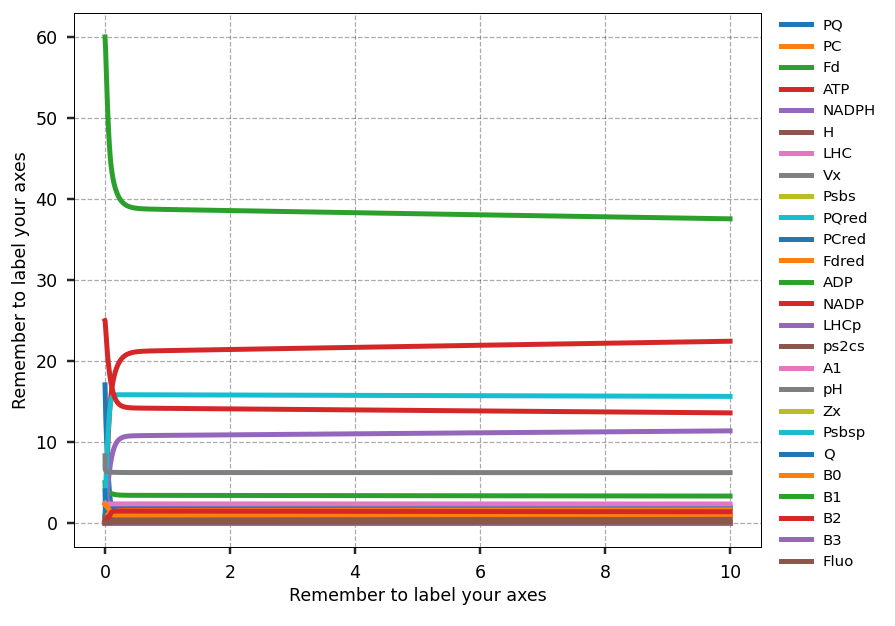

(<Figure size 1000x700 with 1 Axes>,
 <AxesSubplot:xlabel='Remember to label your axes', ylabel='Remember to label your axes'>)

In [31]:
# just check that it works for some light intensity
s.simulate(10)
s.plot_all()

In [26]:
# let's check the reference parameters
petc_model_file.m.get_parameters()

{'PSIItot': 2.5,
 'PSItot': 2.5,
 'PQtot': 17.5,
 'PCtot': 4.0,
 'Fdtot': 5.0,
 'Ctot': 2.5,
 'NADPtot': 25.0,
 'APtot': 60.0,
 'kH': 0.0,
 'kH0': 500000000.0,
 'kF': 62500000.0,
 'k1': 5000000000.0,
 'k1rev': 10000000000.0,
 'k2': 5000000000.0,
 'kStt7': 0.0035,
 'kPph1': 0.0013,
 'KM_ST': 0.2,
 'n_ST': 2.0,
 'staticAntI': 0.2,
 'staticAntII': 0.0,
 'kATPsynth': 20.0,
 'kATPcons': 10.0,
 'ATPcyt': 0.5,
 'Pi_mol': 0.01,
 'DeltaG0_ATP': 30.6,
 'HPR': 4.666666666666667,
 'kNADPHcons': 15.0,
 'NADPHcyt': 0.5,
 'pHstroma': 7.8,
 'kLeak': 0.01,
 'bH': 100.0,
 'kPQred': 250.0,
 'kCytb6f': 2.5,
 'kPTOX': 0.01,
 'kPCox': 2500.0,
 'kFdred': 250000.0,
 'kcatFNR': 500.0,
 'kcyc': 1.0,
 'O2ext': 8.0,
 'kNDH': 0.002,
 'kNh': 0.05,
 'kNr': 0.004,
 'NPQsw': 5.8,
 'nH': 5.0,
 'EFNR': 3.0,
 'KM_FNR_F': 1.56,
 'KM_FNR_N': 0.22,
 'E0_QA': -0.14,
 'E0_PQ': 0.354,
 'E0_cytf': 0.35,
 'E0_PC': 0.38,
 'E0_P700': 0.48,
 'E0_FA': -0.55,
 'E0_Fd': -0.43,
 'E0_NADP': -0.113,
 'F': 96.485,
 'R': 0.0083,
 'T': 298.

In [63]:
data = {} # store the results in a dictionary
varypar = [0.00024, 0.0024, 0.024, 0.24, 2.4]
for i in varypar:
    s = Simulator(petc_model_file.m)
    s.update_parameter('kDeepoxV', i)
    s.initialise(y0dark12_petc)
    s.simulate(1000)
    data[i] = s.get_results_df() # as data frame format you can call simly data[i].PQ or data[i].ATP, any variable

<IPython.core.display.Javascript object>


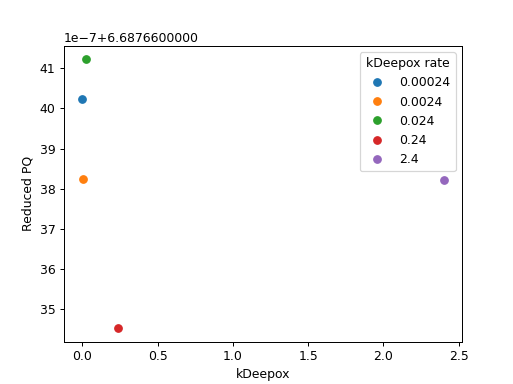

In [69]:
# plot now the PQ values
plt.figure()
for i in varypar:
    plt.plot(i, data[i].PQ.values[-1], 'o', label=i)
plt.ylabel('Reduced PQ')    
plt.xlabel('kDeepox')    
plt.legend(title='kDeepox rate')    
plt.show()
# see, there is not much difference. Please vary some other parameters and always check for the reference and expand the varypar array

In [53]:
data[i].PQ.values[-1]

6.687664122277533